In [1]:
# Import packages
import os
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matrix2latex import matrix2latex
from mpctools.extensions.mplext import plot_matrix
from mpctools.extensions.skext import multi_way_split
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_mutual_info_score, accuracy_score, f1_score, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold, ShuffleSplit
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
%matplotlib inline

# Question 1

In [2]:
data_path1 = os.path.join(os.getcwd(), 'Data/PartA', '20ng_train.csv')
data_path2 = os.path.join(os.getcwd(), 'Data/PartA', '20ng_test.csv')
data_path3 = os.path.join(os.getcwd(), 'Data/PartA', '20ng_labels.csv')
news_train = pd.read_csv(data_path1, delimiter = ',', compression='bz2')
news_test = pd.read_csv(data_path2, delimiter = ',', compression='bz2')
news_labels = pd.read_csv(data_path3, delimiter = ',', compression='bz2')
X_train, y_train, X_test, y_test = news_train.drop('class', axis=1), news_train['class'], news_test.drop('class', axis=1), news_test['class']

In [17]:
news_test.describe()

,__,ability,able,ac,accept,access,according,account,act,action,...,worth,wouldn,write,written,wrong,wrote,year,years,yes,class
count,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,...,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000,1883.000000
mean,0.002292,0.002168,0.007335,0.002817,0.002701,0.004449,0.003012,0.001716,0.001886,0.001745,...,0.003018,0.005356,0.003746,0.003812,0.007960,0.001970,0.006214,0.008706,0.009449,3.345194
std,0.032391,0.021397,0.034312,0.032169,0.021777,0.032393,0.026133,0.022855,0.019504,0.018376,...,0.026231,0.033441,0.028779,0.032836,0.039182,0.020613,0.037389,0.041551,0.043570,2.208286
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000
max,0.864159,0.469412,0.337561,0.620254,0.310053,0.504324,0.420903,0.632166,0.336667,0.387412,...,0.490894,0.481298,0.434553,0.543384,0.470697,0.566179,0.537827,0.532047,0.590114,7.000000


In [14]:
max(news_test.drop('class', axis=1).describe().loc['mean'])

0.02561071134030815

In [5]:
news_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5648 entries, 0 to 5647
Columns: 1001 entries, __ to class
dtypes: float64(1000), int64(1)
memory usage: 43.1 MB


In [21]:
np.concatenate(news_labels.values, axis=0)

array(['comp.sys.ibm.pc.hardware', 'comp.sys.mac.hardware', 'rec.autos',
       'rec.motorcycles', 'sci.crypt', 'sci.electronics',
       'soc.religion.christian', 'talk.religion.misc'], dtype=object)

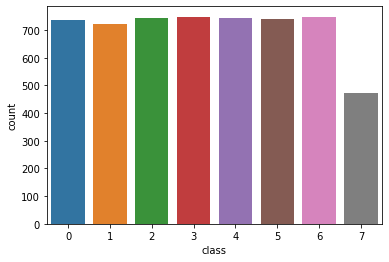

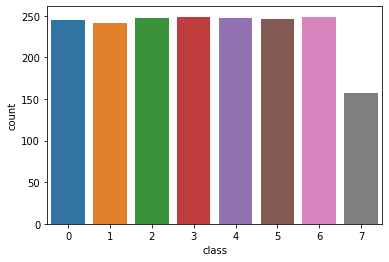

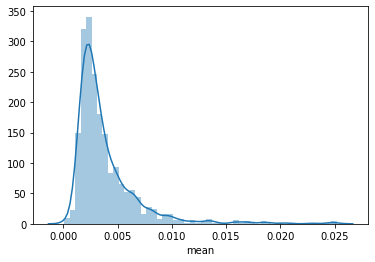

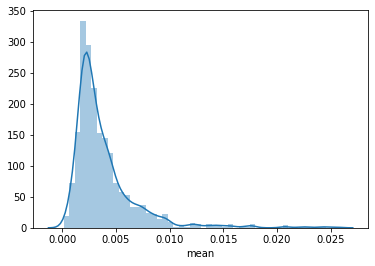

6    748
3    747
4    743
2    742
5    738
0    737
1    722
7    471
Name: class, dtype: int64
6    249
3    249
4    248
2    248
5    246
0    245
1    241
7    157
Name: class, dtype: int64
(5648,)
(1883,)


In [26]:
sns.countplot(x='class', data=news_train)
plt.show()
sns.countplot(x='class', data=news_test)
plt.show()
sns.distplot(X_train.describe().loc['mean'])
plt.show()
sns.distplot(X_test.describe().loc['mean'])
plt.show()
print(y_train.value_counts())
print(y_test.value_counts())
print(y_train.shape)
print(y_test.shape)

### 1.1
The training set consists of 5648 observations, each with a dimensionality of 1000. Each attribute of an observation corresponds to a word, and its value is the TF-IDF weight of that word, which ranges from 0 to 1 in this particular data set. The average values of each attribute range from 0.0001 to 0.0252. The most common attribute value is 0 as not all words appear in a document at once. There is an uneven class distribution as class 7 is almost half as frequent as all of the other classes, this will impact our model classification accuracy as words that belong to class 7 might be misclassified. The distribution of the mean value of each attribute resembles a positively skewed normal distribution with mean roughly around 0.0025.

### 1.2
The testing set consists of 1883 observations with a similar attribute value range to the testing set. The class distribution also closely resembles the training set where class 1 to 6 have similar frequencies while class 7 is almost half as frequent as the other classes. The distribution of the mean value of each attribute also resembles the same distribution of the training set, this supports the assumption for machine learning where the training and testing sets should be sampled from the same distribution, thus lowering the amount of bias from the testing set.

### 1.3
The desired model should take into account how relevant each word is to each document, that is, the words which would most help a human better understand a document whichout reading it all. Relevant words do not necessarily mean the most frequent words, for example, stopwords which are frequent while not offering much meaning. Thus it is important to, not only consider the document, but the dataset as a whole, as we want to distinguish words that are meaningful to a particular document, and not words that appear the most, which TF-IDF tries to measure.

# Question 2

### 2.1
The non-deterministic nature of the K-Means algorithm comes from its random selection of starting centroids, this means that depending on the choice of the starting centroids the algorithm could give rise to entirely different models of the data. The SKLearn implementation of K-Means selects the final model based on which one minimizes Inertia the most.

### 2.2
The observations in the data set each belong to 1 of 8 different classes. This could imply that the observations from each class have similar values in the feature space, thus a reasonable number for this data set could be the number of classes: 8.

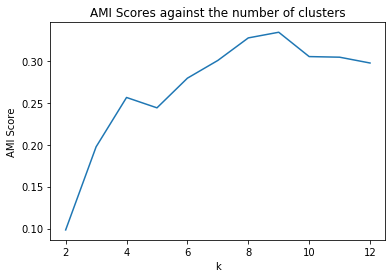

In [31]:
AMIS = []
for i in np.arange(2,13):
    kM = KMeans(n_clusters=i, random_state=1000, n_init=50)
    kM.fit(X_train)
    AMI = adjusted_mutual_info_score(y_train, kM.predict(X_train), average_method='max')
    AMIS.append(AMI)
AMIS

plt.plot(np.arange(2,13), AMIS)
plt.xlabel('k')
plt.ylabel('AMI Score')
plt.title('AMI Scores against the number of clusters')
plt.show()

In [9]:
kM = KMeans(n_clusters=4, random_state=1000, n_init=50)
kM.fit(X_train)
X_predict = kM.predict(X_train)

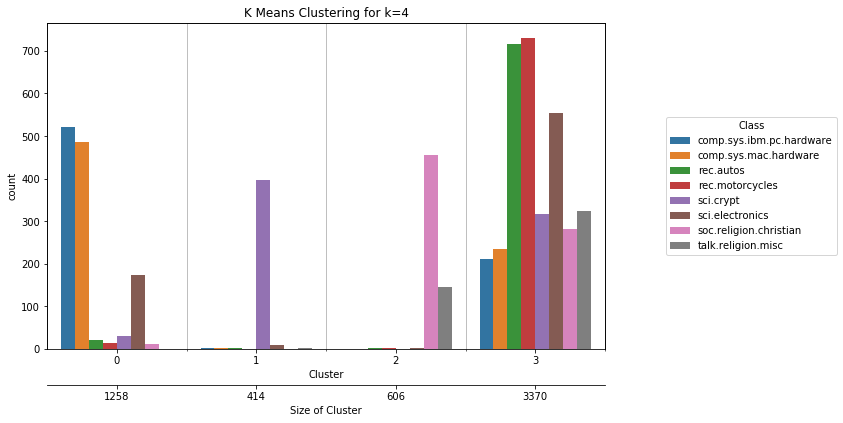

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
ax = sns.countplot(x=X_predict, hue=y_train, ax=ax)
ax.legend(labels=np.concatenate(news_labels.values, axis=0), #  mixture class does not appear
          loc='center left', bbox_to_anchor=[1.1, 0.5], title='Class')
plt.gca().set_xticks([i + 0.5 for i in range(4)], minor=True)
plt.grid(True, which='minor')
plt.xlabel('Cluster')
plt.title('K Means Clustering for k=4')

ax2 = ax.twiny()
ax2.set_xticks(range(4))
ax2.set_xticklabels(np.bincount(kM.labels_))
ax2.xaxis.set_ticks_position('bottom')
ax2.xaxis.set_label_position('bottom')
ax2.spines['bottom'].set_position(('outward',36))
ax2.set_xlim(ax.get_xlim())
ax2.set_xlabel('Size of Cluster')
plt.show()

In [27]:
np.bincount(kM.labels_)

array([1258,  414,  606, 3370], dtype=int64)

# Question 3

In [37]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=0)

In [38]:
dominant_class = y_train.value_counts().idxmax()
print('Class with highest prior probability: {}'.format(dominant_class))
print("F1 score on testing set: {:.3f}".format(f1_score(y_test, np.full_like(y_test, dominant_class), average="macro")))

Class with highest prior probability: 6
F1 score on testing set: 0.029


C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [39]:
lr = LogisticRegression(solver="lbfgs", multi_class="multinomial", random_state=0)

In [7]:
f1_scores = []
for train_index, test_index in skf.split(X_train, y_train):
    XVal_train, yVal_train, XVal_test, yVal_test = X_train.iloc[train_index], y_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[test_index]
    lr.fit(XVal_train, yVal_train)
    f1 = f1_score(yVal_test, lr.predict(XVal_test), average="macro")
    f1_scores.append(f1)

In [8]:
print("Average of validation set F1 scores: {:.3f}".format(np.mean(f1_scores)))
print("Standard Deviation of validation set F1 scores: {:.3f}".format(np.std(f1_scores)))

Average of validation set F1 scores: 0.669
Standard Deviation of validation set F1 scores: 0.017


In [14]:
np.logspace(-4,5, num=19)

array([1.00000000e-04, 3.16227766e-04, 1.00000000e-03, 3.16227766e-03,
       1.00000000e-02, 3.16227766e-02, 1.00000000e-01, 3.16227766e-01,
       1.00000000e+00, 3.16227766e+00, 1.00000000e+01, 3.16227766e+01,
       1.00000000e+02, 3.16227766e+02, 1.00000000e+03, 3.16227766e+03,
       1.00000000e+04, 3.16227766e+04, 1.00000000e+05])

In [15]:
C = np.logspace(-4,5, num=19)

f1_avgt = []
f1_avgv = []
for i in np.arange(19):
    lr = LogisticRegression(solver="lbfgs", multi_class="multinomial", random_state=0, C=C[i])
    f1_train = []
    f1_val = []
    
    for train_index, test_index in skf.split(X_train, y_train):
        XVal_train, yVal_train, XVal_test, yVal_test = X_train.iloc[train_index], y_train.iloc[train_index], X_train.iloc[test_index], y_train.iloc[test_index]
        lr.fit(XVal_train, yVal_train)
        f1_t = f1_score(yVal_train, lr.predict(XVal_train), average="macro")
        f1_train.append(f1_t)
        f1_v = f1_score(yVal_test, lr.predict(XVal_test), average="macro")
        f1_val.append(f1_v)

    f1_avgt.append(np.mean(f1_train))
    f1_avgv.append(np.mean(f1_val))
    print("For C = {}\nAverage of train : {}\nAverage of test : {}\n".format(C[i], f1_avgt[i], f1_avgv[i]))

C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

For C = 0.0001
Average of train : 0.1072384782041148
Average of test : 0.10426652383342358



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

For C = 0.00031622776601683794
Average of train : 0.21485270763655584
Average of test : 0.20693715644729807



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

For C = 0.001
Average of train : 0.4184069235211976
Average of test : 0.3978221586555387



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

For C = 0.0031622776601683794
Average of train : 0.5835871117895345
Average of test : 0.549401889558099



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

For C = 0.01
Average of train : 0.6286982582391885
Average of test : 0.5903162727489074



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predict

For C = 0.03162277660168379
Average of train : 0.6414261892791014
Average of test : 0.6007943890141922



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


For C = 0.1
Average of train : 0.6846299833794127
Average of test : 0.6231661213731127

For C = 0.31622776601683794
Average of train : 0.7587493540377247
Average of test : 0.6632928459845525

For C = 1.0
Average of train : 0.8169961852556071
Average of test : 0.6689909262264606



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 3.1622776601683795
Average of train : 0.8662005498458976
Average of test : 0.6618615893645126



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 10.0
Average of train : 0.9167343830776321
Average of test : 0.6508673013752745



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 31.622776601683793
Average of train : 0.9495438867114654
Average of test : 0.6351927624582812



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 100.0
Average of train : 0.9628699829228949
Average of test : 0.6306581456843349



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 316.22776601683796
Average of train : 0.9660640884699557
Average of test : 0.6290397926441794



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 1000.0
Average of train : 0.9677569684046405
Average of test : 0.6265514299120727



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 3162.2776601683795
Average of train : 0.9679482183334336
Average of test : 0.626067344281533



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 10000.0
Average of train : 0.9680810687533761
Average of test : 0.6212917640148401



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 31622.776601683792
Average of train : 0.9681316931090306
Average of test : 0.622603362670217



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: Conver

For C = 100000.0
Average of train : 0.9681875088913923
Average of test : 0.6196887999912131



C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\sklearn\linear_model\logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


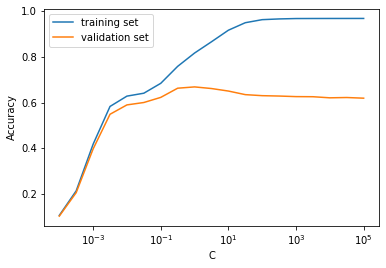

In [25]:
fig = plt.figure()
ax = fig.add_subplot()
ax.plot(C, f1_avgt, label='training set')
ax.plot(C, f1_avgv, label='validation set')
ax.set_xscale('log')
plt.legend()
plt.xlabel('C')
plt.ylabel('Accuracy')
plt.show()

In [40]:
lr = LogisticRegression(solver="lbfgs", multi_class="multinomial", random_state=0, C=1, max_iter=200)
lr.fit(X_train, y_train)
f1 = f1_score(y_test, lr.predict(X_test), average="macro")
print('Score of best model on testing set: {}'.format(f1))

Score of best model on testing set: 0.6747698176259582


# Question 4

In [2]:
data_path4 = os.path.join(os.getcwd(), 'Data/PartB', 'BristolAir_Exploratory.csv')
BA_ex = pd.read_csv(data_path4, delimiter = ',', compression='bz2')

In [5]:
BA_ex[BA_ex['SiteID'] == 0].shape

(6446, 7)

In [26]:
total = 0
for i in np.arange(18):
    total = total + len(BA_ex[BA_ex['SiteID'] == i])
print(total)
print(BA_ex.shape)

1306758
(1306758, 7)


In [11]:
df = pd.DataFrame(columns=['SiteID', 'Number of Samples', 'Percentage of Problematic Samples'])
df

,SiteID,Number of Samples,Percentage of Problematic Samples


In [13]:
for i in np.arange(18):
    num = BA_ex['SiteID'].value_counts()[i]
    df.loc[i] = [i, num, len(miss[miss['SiteID'] == i]) / num * 100]
print(df.to_latex())

\begin{tabular}{lrrr}
\toprule
{} &  SiteID &  Number of Samples &  Percentage of Problematic Samples \\
\midrule
0  &     0.0 &             6446.0 &                           1.613404 \\
1  &     1.0 &           163111.0 &                           6.290195 \\
2  &     2.0 &            62990.0 &                           4.353072 \\
3  &     3.0 &            25464.0 &                          78.110273 \\
4  &     4.0 &            74787.0 &                           2.072553 \\
5  &     5.0 &           113952.0 &                           8.828279 \\
6  &     6.0 &           142141.0 &                           7.446831 \\
7  &     7.0 &           115162.0 &                           4.472830 \\
8  &     8.0 &            43824.0 &                          21.056955 \\
9  &     9.0 &            22071.0 &                           5.301074 \\
10 &    10.0 &            96407.0 &                           3.594137 \\
11 &    11.0 &            20693.0 &                           1.981346 \

In [46]:
len(BA_ex[BA_ex.isnull().any(axis=1) == True])

118872

In [30]:
a = BA_ex[BA_ex['NOx'] < 0].append(BA_ex[BA_ex['NO2'] < 0])
a = a.append(BA_ex[BA_ex['NO'] < 0])
a = a.drop_duplicates()
a = a.append(BA_ex[BA_ex.isnull().any(axis=1) == True])
idx = a.index.unique()
miss = BA_ex.iloc[idx]
print(BA_ex[BA_ex['SiteID'] == 15].to_latex())

\begin{tabular}{llrrrrrr}
\toprule
{} &                  Date Time &  NOx &  NO2 &  NO &  SiteID &   Loc.Lat &  Loc.Long \\
\midrule
12090   &  2019-03-28 23:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12093   &  2019-03-29 11:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12096   &  2019-03-30 14:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12099   &  2019-04-02 20:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12102   &  2019-04-02 21:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12105   &  2019-04-04 06:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12108   &  2019-04-06 14:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12111   &  2019-04-08 02:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12114   &  2019-04-11 08:00:00+00:00 &  NaN &  NaN & NaN &      15 &  51.45795 & -2.583989 \\
12117   &  2019-04-12

In [49]:
miss.head()

,Date Time,NOx,NO2,NO,SiteID,Loc.Lat,Loc.Long
4798,1999-01-10 01:00:00+00:00,-30.89,-3.87,-17.61,3,51.475285,-2.56208
4801,1999-01-10 12:00:00+00:00,-30.36,-3.87,-17.27,3,51.475285,-2.56208
26089,1999-01-10 05:00:00+00:00,-30.79,-3.92,-17.52,3,51.475285,-2.56208
26093,1999-01-11 00:00:00+00:00,-30.84,-4.11,-17.46,3,51.475285,-2.56208
44985,1999-11-09 08:00:00+00:00,-17.40,-3.83,-8.85,3,51.475285,-2.56208


In [50]:
data_315 = BA_ex.loc[(BA_ex['SiteID'] != 3) & (BA_ex['SiteID'] != 15)]

In [51]:
data_315.drop(columns=['Loc.Lat', 'Loc.Long', 'SiteID']).corr(method='pearson')

,NOx,NO2,NO
NOx,1.000000,0.878016,0.988019
NO2,0.878016,1.000000,0.807853
NO,0.988019,0.807853,1.000000


In [52]:
data_path5 = os.path.join(os.getcwd(), 'Data/PartB', 'BristolAir_SiteAligned.csv')
BA_sa = pd.read_csv(data_path5, delimiter = ',', compression='bz2', header=[0, 1], parse_dates=[0])

In [53]:
BA_sa.head()

Date Time    NOx                                        \
         Unnamed: 0_level_1      1       2       4       6     7      10   
0 2009-03-14 04:00:00+00:00  10.50   15.25   21.50   23.75   8.0   53.25   
1 2009-03-14 05:00:00+00:00   9.75    9.50   11.50   23.25  10.0   30.50   
2 2009-03-15 17:00:00+00:00  67.25   88.75   66.00  163.75  36.0  203.75   
3 2009-03-17 13:00:00+00:00  71.75  124.50  135.00   96.50  38.0  172.50   
4 2009-03-17 15:00:00+00:00  82.00  125.00  104.25  106.50  36.0  193.00   

                         ...     NO                                          \
      12      14     16  ...      1      2      4      6    7     10     12   
0   19.0  201.75   40.0  ...   2.75   2.25   4.00   8.75  0.0  12.50    3.0   
1   19.0  138.00   42.0  ...   3.00   2.75   3.00   8.50  0.0   5.75    3.0   
2  155.0  429.00   94.0  ...  18.25  27.00  16.50  57.25  3.0  69.75   51.0   
3  338.0  734.00  196.5  ...  17.75  53.25  46.25  34.75  6.0  61.50  139.0   
4  321.0  679.00  329.0  ...  21.50  47.50  34.25  36.50  5.0  63.75  130.0   

                          
       14      16     17  
0   64.75   12.50   2.50  
1   38.50   12.25   2.25  
2  177.00   21.50  28.50  
3  345.50   71.00  47.00  
4  305.25  134.25  45.50  

[5 rows x 31 columns]

In [54]:
group1 = BA_sa.drop(columns='Date Time').groupby(level=0, axis=1).get_group('NOx').corr(method='pearson')
group1 = group1.droplevel(level=0, axis=1).droplevel(level=0, axis=0)
group2 = BA_sa.drop(columns='Date Time').groupby(level=0, axis=1).get_group('NO2').corr(method='pearson')
group2 = group2.droplevel(level=0, axis=1).droplevel(level=0, axis=0)
group3 = BA_sa.drop(columns='Date Time').groupby(level=0, axis=1).get_group('NO').corr(method='pearson')
group3 = group3.droplevel(level=0, axis=1).droplevel(level=0, axis=0)

C:\Users\DAVID\Anaconda3\envs\iamlassignment2\lib\site-packages\pandas\core\generic.py:3946: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  new_axis = axis.drop(labels, errors=errors)


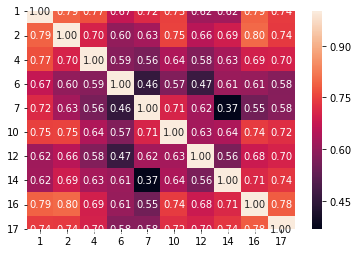

In [72]:
#ax = plt.axes()
#ax.set_ylim((0,))
#plot_matrix(group1.to_numpy(), show_val=True, mode='heatmap', labels=[1, 2, 4, 6, 7, 10, 12, 14, 16, 17], ax=ax)

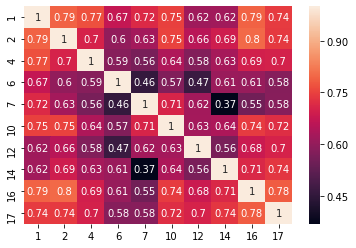

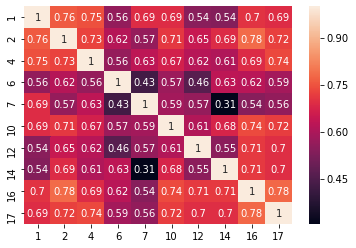

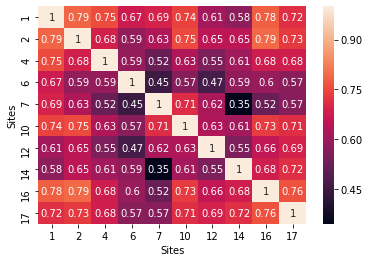

In [178]:
sns.heatmap(group1, annot=True)
plt.show()
sns.heatmap(group2, annot=True)
plt.show()
sns.heatmap(group3, annot=True)
plt.xlabel('Sites')
plt.ylabel('Sites')
plt.show()

# Question 5

In [27]:
data_path5 = os.path.join(os.getcwd(), 'Data/PartB', 'BristolAir_DayAligned.csv')
BA_da = pd.read_csv(data_path5, delimiter = ',', compression='bz2', index_col=['SiteID', 'Date'])

In [28]:
BA_da.head()

0      1     2      3       4       5       6       7  \
SiteID Date                                                                    
1      2004-07-02  25.25  18.00  12.5   9.25    8.75   14.50   18.50   30.75   
       2004-07-03  22.25  21.00  23.5  33.75   15.50    9.00   14.00   57.75   
       2004-07-04  28.25  22.25  32.0  34.50   50.50   76.50  165.75  170.00   
       2004-07-05  56.75  62.50  79.5  78.50  115.75  149.00  175.00  119.00   
       2004-07-06  94.25  68.25  44.5  47.67   31.75   28.25   31.75   55.75   

                       8      9  ...     62     63    64     65     66     67  \
SiteID Date                      ...                                            
1      2004-07-02  35.25  39.00  ...  14.25  13.75  12.0  12.50  10.75  10.50   
       2004-07-03  49.75  49.75  ...  12.00  10.25  11.0  14.75  12.50  11.50   
       2004-07-04  63.25  57.75  ...  19.25  29.75  17.5  26.50  18.25  18.75   
       2004-07-05  83.75  94.75  ...  19.25  23.50  12.0  15.50  12.50  13.50   
       2004-07-06  41.00  37.75  ...   3.25   2.25   3.0   2.00   2.00   1.00   

                      68     69     70     71  
SiteID Date                                    
1      2004-07-02   9.25   9.00   7.75  10.75  
       2004-07-03   5.75   8.25   6.25   1.25  
       2004-07-04  12.50  14.00  20.75  26.00  
       2004-07-05  17.75  38.00  39.25  21.50  
       2004-07-06   0.75   0.75   1.00   0.25  

[5 rows x 72 columns]

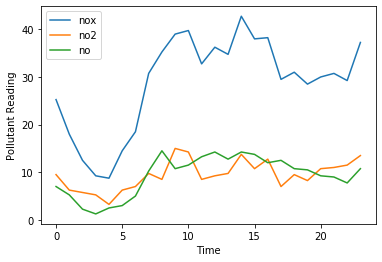

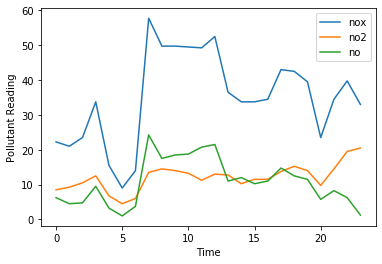

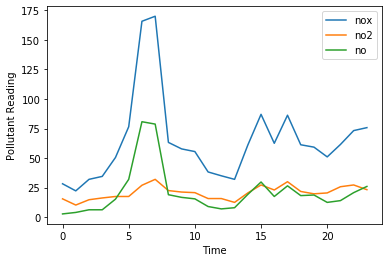

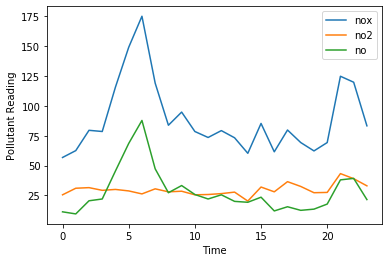

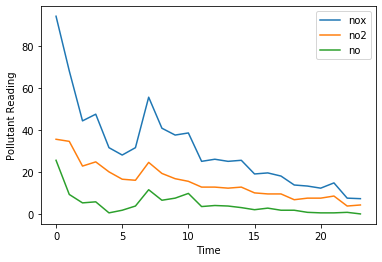

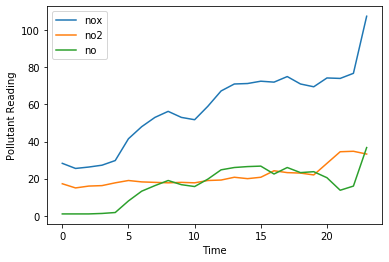

In [29]:
for i in np.arange(6):
    nox = BA_da.iloc[i][0:24].to_numpy()
    no2 = BA_da.iloc[i][24:48].to_numpy()
    no = BA_da.iloc[i][48:72].to_numpy()
    plt.plot(np.arange(24), nox)
    plt.plot(np.arange(24), no2)
    plt.plot(np.arange(24), no)
    plt.legend(['nox', 'no2', 'no'])
    plt.xlabel('Time')
    plt.ylabel('Pollutant Reading')
    plt.show()

In [32]:
BA_da.head()

0      1     2      3       4       5       6       7  \
SiteID Date                                                                    
1      2004-07-02  25.25  18.00  12.5   9.25    8.75   14.50   18.50   30.75   
       2004-07-03  22.25  21.00  23.5  33.75   15.50    9.00   14.00   57.75   
       2004-07-04  28.25  22.25  32.0  34.50   50.50   76.50  165.75  170.00   
       2004-07-05  56.75  62.50  79.5  78.50  115.75  149.00  175.00  119.00   
       2004-07-06  94.25  68.25  44.5  47.67   31.75   28.25   31.75   55.75   

                       8      9  ...     62     63    64     65     66     67  \
SiteID Date                      ...                                            
1      2004-07-02  35.25  39.00  ...  14.25  13.75  12.0  12.50  10.75  10.50   
       2004-07-03  49.75  49.75  ...  12.00  10.25  11.0  14.75  12.50  11.50   
       2004-07-04  63.25  57.75  ...  19.25  29.75  17.5  26.50  18.25  18.75   
       2004-07-05  83.75  94.75  ...  19.25  23.50  12.0  15.50  12.50  13.50   
       2004-07-06  41.00  37.75  ...   3.25   2.25   3.0   2.00   2.00   1.00   

                      68     69     70     71  
SiteID Date                                    
1      2004-07-02   9.25   9.00   7.75  10.75  
       2004-07-03   5.75   8.25   6.25   1.25  
       2004-07-04  12.50  14.00  20.75  26.00  
       2004-07-05  17.75  38.00  39.25  21.50  
       2004-07-06   0.75   0.75   1.00   0.25  

[5 rows x 72 columns]

In [44]:
site1 = BA_da[BA_da.index.get_level_values(0) == 1]
np.cumsum(pca.explained_variance_ratio_)

array([0.58900596, 0.72722179, 0.79409131, 0.84625699, 0.8853502 ,
       0.90585433, 0.9201634 , 0.93238651, 0.94223464, 0.94976523,
       0.95646117, 0.9620975 , 0.96645848, 0.97056908, 0.97396026,
       0.97674456, 0.97922803, 0.98149213, 0.98373034, 0.98571006,
       0.98757322, 0.98936403, 0.99094829, 0.99222474, 0.9934267 ,
       0.99451716, 0.99551051, 0.99632472, 0.99691798, 0.99749834,
       0.99798769, 0.9982737 , 0.99853736, 0.99872223, 0.99887998,
       0.99901181, 0.99911673, 0.99921638, 0.999296  , 0.99937332,
       0.99944269, 0.99950428, 0.99956205, 0.9996179 , 0.99967195,
       0.99971944, 0.99976566, 0.9998091 , 0.99984913, 0.99988626,
       0.99991856, 0.99994037, 0.9999533 , 0.9999643 , 0.99996957,
       0.99997434, 0.99997803, 0.999981  , 0.99998339, 0.99998548,
       0.99998737, 0.99998905, 0.99999053, 0.99999192, 0.99999323,
       0.99999442, 0.99999556, 0.99999663, 0.99999764, 0.99999862,
       0.9999994 , 1.        ])

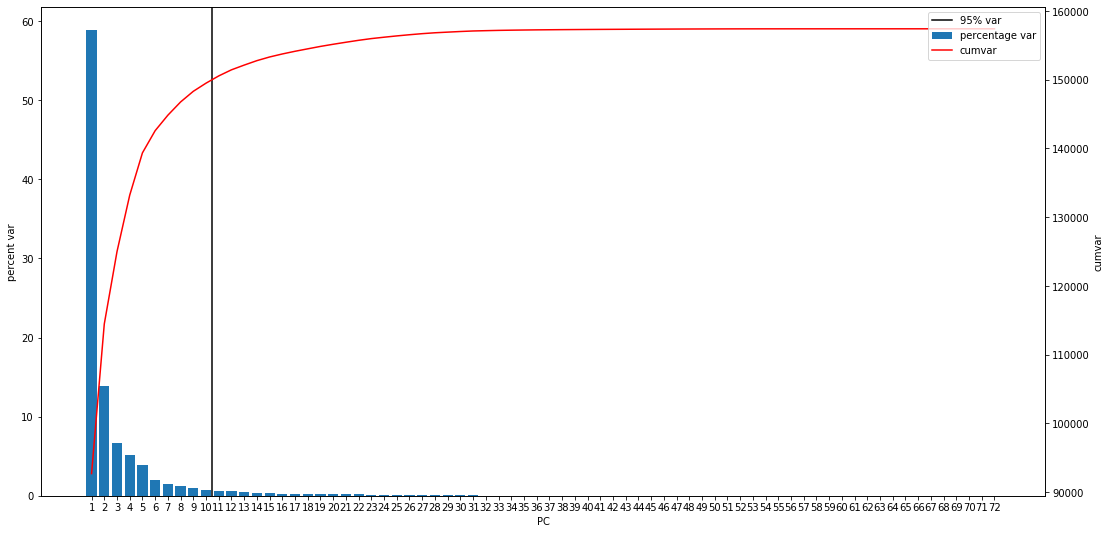

In [34]:
pca = PCA(n_components=72, random_state=72)
pca.fit(site1)
fig, ax1 = plt.subplots()
fig.set_figheight(9)
fig.set_figwidth(18)
lns1 = ax1.bar(np.arange(1,73), height=pca.explained_variance_ratio_*100, align='center', width=0.8, label='percentage var')
ax1.set_ylabel('percent var')
ax1.set_xlabel('PC')
ax2 = ax1.twinx()
lns2 = ax2.plot(np.arange(1,73), np.cumsum(pca.explained_variance_), color='red', label = 'cumvar')
plt.ylabel('cumvar')
plt.xticks(np.arange(1,73), fontsize=7)
lns3 = ax1.axvline(x=10.5, color='black', label='95% var')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax2.legend(lines+lines2, labels+labels2, loc='upper right')
plt.show()

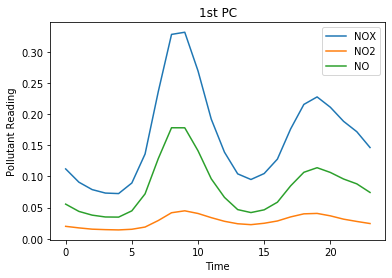

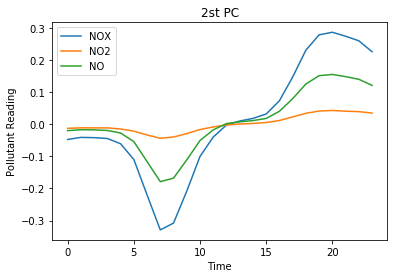

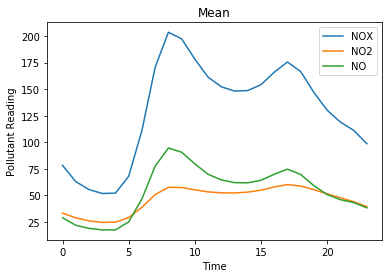

In [48]:
pca1 = pca.components_[0]
pca2 = pca.components_[1]
mean = BA_da.mean()

nox = pca1[0:24]
no2 = pca1[24:48]
no = pca1[48:72]
plt.plot(np.arange(24), nox)
plt.plot(np.arange(24), no2)
plt.plot(np.arange(24), no)
plt.legend(['NOX', 'NO2', 'NO'])
plt.xlabel('Time')
plt.ylabel('Pollutant Reading')
plt.title('1st PC')
plt.show()

nox = pca2[0:24]
no2 = pca2[24:48]
no = pca2[48:72]
plt.plot(np.arange(24), nox)
plt.plot(np.arange(24), no2)
plt.plot(np.arange(24), no)
plt.legend(['NOX', 'NO2', 'NO'])
plt.xlabel('Time')
plt.ylabel('Pollutant Reading')
plt.title('2st PC')
plt.show()

nox = mean[0:24]
no2 = mean[24:48]
no = mean[48:72]
plt.plot(np.arange(24), nox)
plt.plot(np.arange(24), no2)
plt.plot(np.arange(24), no)
plt.legend(['NOX', 'NO2', 'NO'])
plt.xlabel('Time')
plt.ylabel('Pollutant Reading')
plt.title('Mean')
plt.show()

# Question 6

In [2]:
data_path5 = os.path.join(os.getcwd(), 'Data/PartB', 'BristolAir_SiteAligned.csv')
BA_sa = pd.read_csv(data_path5, delimiter = ',', compression='bz2', header=[0, 1], parse_dates=[0])

In [3]:
BA_sa.head()

Date Time    NOx                                        \
         Unnamed: 0_level_1      1       2       4       6     7      10   
0 2009-03-14 04:00:00+00:00  10.50   15.25   21.50   23.75   8.0   53.25   
1 2009-03-14 05:00:00+00:00   9.75    9.50   11.50   23.25  10.0   30.50   
2 2009-03-15 17:00:00+00:00  67.25   88.75   66.00  163.75  36.0  203.75   
3 2009-03-17 13:00:00+00:00  71.75  124.50  135.00   96.50  38.0  172.50   
4 2009-03-17 15:00:00+00:00  82.00  125.00  104.25  106.50  36.0  193.00   

                         ...     NO                                          \
      12      14     16  ...      1      2      4      6    7     10     12   
0   19.0  201.75   40.0  ...   2.75   2.25   4.00   8.75  0.0  12.50    3.0   
1   19.0  138.00   42.0  ...   3.00   2.75   3.00   8.50  0.0   5.75    3.0   
2  155.0  429.00   94.0  ...  18.25  27.00  16.50  57.25  3.0  69.75   51.0   
3  338.0  734.00  196.5  ...  17.75  53.25  46.25  34.75  6.0  61.50  139.0   
4  321.0  679.00  329.0  ...  21.50  47.50  34.25  36.50  5.0  63.75  130.0   

                          
       14      16     17  
0   64.75   12.50   2.50  
1   38.50   12.25   2.25  
2  177.00   21.50  28.50  
3  345.50   71.00  47.00  
4  305.25  134.25  45.50  

[5 rows x 31 columns]

In [4]:
NOx = BA_sa.groupby(axis=1, level=0).get_group('NOx')
X = NOx.drop(columns='17', level=1)
y = NOx['NOx']['17']

In [5]:
idx = multi_way_split(y, [0.6, 0.15, 0.25], ShuffleSplit, random_state=0)
X_train, X_val, X_test = X.iloc[idx[0]], X.iloc[idx[1]], X.iloc[idx[2]]
print("Size of training set : {}\nSize of validation set : {}\nSize of testing set : {}".format(X_train.shape, X_val.shape, X_test.shape))

Size of training set : (8937, 9)
Size of validation set : (2234, 9)
Size of testing set : (3724, 9)


In [6]:
y.iloc[idx[0]]

8550     402.75
5582      69.75
3153      44.75
10322    441.75
13556     15.50
          ...  
13123     77.75
3264     140.50
9845     156.75
10799     71.50
2732      56.75
Name: 17, Length: 8937, dtype: float64

In [7]:
baseline_predict = y.mean()
print("RMSE of training set : {}".format(np.sqrt(mean_squared_error(y.iloc[idx[0]], np.full_like(y.iloc[idx[0]], baseline_predict)))))
print("RMSE of validation set : {}".format(np.sqrt(mean_squared_error(y.iloc[idx[1]], np.full_like(y.iloc[idx[1]], baseline_predict)))))

RMSE of training set : 79.71428788140615
RMSE of validation set : 80.21061649413826


In [27]:
lr = LinearRegression()
lr.fit(X_train, y.iloc[idx[0]])
print("RMSE of training set : {}".format(np.sqrt(mean_squared_error(y.iloc[idx[0]], lr.predict(X_train)))))
print("RMSE of validation set : {}".format(np.sqrt(mean_squared_error(y.iloc[idx[1]], lr.predict(X_val)))))
print("Performance of training set : {}".format(lr.score(X_train, y.iloc[idx[0]])))
print("Performance of validation set : {}".format(lr.score(X_val, y.iloc[idx[1]])))

RMSE of training set : 39.83472027954455
RMSE of validation set : 41.12740349422
Performance of training set : 0.7502784540105178
Performance of validation set : 0.736958153044227


In [9]:
lr = LinearRegression(normalize=True)
lr.fit(X_train, y.iloc[idx[0]])

params = lr.coef_
total = 0;
for i in np.arange(9):
    total = total + np.abs(params[i])
for i in np.arange(9):
    params[i] = np.abs(params[i]) / total

params = pd.DataFrame({'Coeff': params}, index = X.droplevel(level=0, axis=1).columns)
display(params)

,Coeff
1,0.146078
2,0.012575
4,0.169571
6,0.008595
7,0.075074
10,0.100852
12,0.163212
14,0.119470
16,0.204573


In [10]:
kNN = KNeighborsRegressor(n_jobs=-1)
kNN.fit(X_train, y.iloc[idx[0]])
print("Training Set Performance : {}".format(kNN.score(X_train, y.iloc[idx[0]])))
print("Validation Set Performance : {}".format(kNN.score(X_val, y.iloc[idx[1]])))

Training Set Performance : 0.8344230451139573
Validation Set Performance : 0.7473457720103046


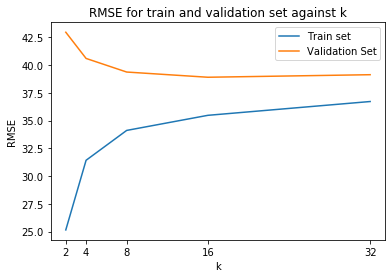

[42.95551269008171, 40.595609577419665, 39.37125304834977, 38.901851355962386, 39.13083888473987]


In [34]:
RMSE_T = []
RMSE_V = []
for i in [2, 4, 8, 16, 32]:
    kNN = KNeighborsRegressor(n_neighbors=i, n_jobs=-1)
    kNN.fit(X_train, y.iloc[idx[0]])
    RMSE_T.append(np.sqrt(mean_squared_error(y.iloc[idx[0]], kNN.predict(X_train))))
    RMSE_V.append(np.sqrt(mean_squared_error(y.iloc[idx[1]], kNN.predict(X_val))))

fig, ax = plt.subplots()
ax.plot([2, 4, 8, 16, 32], RMSE_T)
ax.plot([2, 4, 8, 16, 32], RMSE_V)
ax.set_xlabel('k')
ax.set_ylabel('RMSE')
plt.title('RMSE for train and validation set against k')
ax.legend(['Train set', 'Validation Set'])
ax.set_xticks([2, 4, 8, 16, 32])
plt.show()
print(RMSE_V)

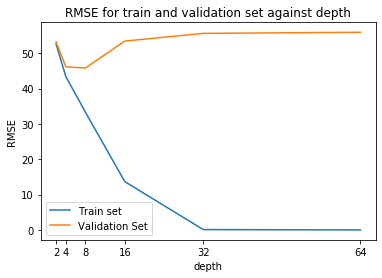

[53.25095179219833, 46.12769116861275, 45.84380928287788, 53.4486396323909, 55.62441997967441, 55.9470657647145]


In [36]:
RMSE_T = []
RMSE_V = []
for i in [2, 4, 8, 16, 32, 64]:
    dtr = DecisionTreeRegressor(max_depth=i, random_state=0)
    dtr.fit(X_train, y.iloc[idx[0]])
    RMSE_T.append(np.sqrt(mean_squared_error(y.iloc[idx[0]], dtr.predict(X_train))))
    RMSE_V.append(np.sqrt(mean_squared_error(y.iloc[idx[1]], dtr.predict(X_val))))

fig, ax = plt.subplots()
ax.plot([2, 4, 8, 16, 32, 64], RMSE_T)
ax.plot([2, 4, 8, 16, 32, 64], RMSE_V)
ax.set_xlabel('depth')
ax.set_ylabel('RMSE')
plt.title('RMSE for train and validation set against depth')
ax.legend(['Train set', 'Validation Set'])
ax.set_xticks([2, 4, 8, 16, 32, 64])
plt.show()
print(RMSE_V)

In [39]:
X = X_train.append(X_val)
y_train = y.iloc[idx[0]].append(y.iloc[idx[1]])
#baseline
RMSE = []
RMSE.append(np.sqrt(mean_squared_error(y.iloc[idx[2]], np.full_like(y.iloc[idx[2]], baseline_predict))))
#linear regression
lr = LinearRegression()
lr.fit(X, y_train)
RMSE.append(np.sqrt(mean_squared_error(y.iloc[idx[2]], lr.predict(X_test))))
#kNN
kNN = KNeighborsRegressor(n_neighbors=16, n_jobs=-1)
kNN.fit(X, y_train)
RMSE.append(np.sqrt(mean_squared_error(y.iloc[idx[2]], kNN.predict(X_test))))
#Decision Tree
dtr = DecisionTreeRegressor(max_depth=8, random_state=0)
dtr.fit(X, y_train)
RMSE.append(np.sqrt(mean_squared_error(y.iloc[idx[2]], dtr.predict(X_test))))
print(RMSE)

[78.93731200737979, 40.509026852617026, 37.98496506868247, 43.06887110128105]
